In [1]:
import numpy as np
import caffe
import scipy.io
import pickle
import matplotlib.pyplot as plt, mpld3
%matplotlib inline

/Library/Python/2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Library/Python/2.7/site-packages/ipykernel/pylab/config.py:114: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  """)


In [2]:
# Load the model and saved weights
caffe_root = './'  # this file is expected to be in {caffe_root}
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'examples/mnist/lenet_train_test.prototxt',
                caffe_root + 'examples/mnist/lenet_iter_10000.caffemodel',
                caffe.TEST)

In [3]:
# Save the weights to a mat file

mdict = {}
for lyr in net.params:
    mdict[lyr] = net.params[lyr][0].data
    
mdict_top = {}
mdict_top['Weights'] = mdict
ModelSizeOrig = 1722704

WeightMat = 'LeNet_weights.mat'
scipy.io.savemat(WeightMat, mdict_top)

In [4]:
# Some helper functions

def dumpExpt(Expt):
    ExptMat = Expt['ExptMat']
    Expt_top = {}
    Expt_top['Expt'] = Expt
    scipy.io.savemat(ExptMat, Expt_top)
    
def populate(Expt, prefix):
    Expt['ExptMat'] = prefix + '_' + Expt['name'] + '.mat'
    Expt['OutMat']  = prefix + '_' + Expt['name'] + '_SparseWeights.mat'
    Expt['ResMat']  = prefix + '_' + Expt['name'] + '_results.pkl'

def getW(matW):
    W = {}
    for lyr in matW._fieldnames:
        W[lyr] = getattr(matW, lyr)
    return W

def getWeightsAndSizes(Expt):
    OutMat = Expt['OutMat']
    Sprf = scipy.io.loadmat(OutMat, struct_as_record=False)
    sprfW_arr = list(Sprf['SparseWeights'][0])
    size_arr = Sprf['ModelSizes'][0]
    for trialNum in range(len(Expt['Trials'])):
        matW = sprfW_arr[trialNum][0][0]
        W = getW(matW)
        Expt['Trials'][trialNum]['SparseWeights'] = W
        Expt['Trials'][trialNum]['size'] = size_arr[trialNum]
        
def addTrials(Expt):
    Trials = []
    for xVar in Expt['xVars']:
        trial = {}
        trial['xVar'] = xVar
        Trials.append(trial)
    Expt['Trials'] = Trials
    
def dumpResults(Expt):
    filename = Expt['ResMat']
    output = open(filename, 'wb')
    pickle.dump(Expt, output)
    output.close()

In [5]:
# Design experiments and save the parameters to a mat file

prefix = 'LeNet'

# Experiment 1
Expt1 = {}
Expt1['name'] = 'Expt1'
Expt1['mode'] = 'dropLow'
Expt1['xVar_interp'] = 'Drop bottom xVar fraction overall'
step = 0.1
xVars = np.arange(0, 0.9, step)
Expt1['xVars'] = xVars


# Experiment 2
Expt2 = {}
Expt2['name'] = 'Expt2'
Expt2['mode'] = 'dropOutputwise'
Expt2['xVar_interp'] = 'Drop bottom xVar fraction outputwise'
step = 0.1
xVars = np.arange(0, 0.9, step)
Expt2['xVars'] = xVars


# Experiment 3
Expt3 = {}
Expt3['name'] = 'Expt3'
Expt3['mode'] = 'LowRank_incoh'
Expt3['xVar_interp'] = 'incoherence'
step = 10
xVars = np.arange(10, 100 + step/2, step)
Expt3['xVars'] = xVars


# Experiment 4
Expt4 = {}
Expt4['name'] = 'Expt4'
Expt4['mode'] = 'LowRankSparse'
Expt4['xVar_interp'] = 'Maximum rank of the low rank component'
step = 10
xVars = np.arange(10, 100 + step/2, step)
Expt4['xVars'] = xVars

# Experiment 5
Expt5 = {}
Expt5['name'] = 'Expt5'
Expt5['mode'] = 'LowRank'
Expt5['xVar_interp'] = 'Maximum rank of the low rank component'
step = 10
xVars = np.arange(10, 100 + step/2, step)
Expt5['xVars'] = xVars

# Experiment 6
Expt6 = {}
Expt6['name'] = 'Expt6'
Expt6['mode'] = 'quantize'
Expt6['xVar_interp'] = 'Bits to store each element'
xVars = [1, 2, 4, 8, 16, 32]
Expt6['xVars'] = xVars

# Experiment 7
Expt7 = {}
Expt7['name'] = 'Expt7'
Expt7['mode'] = 'LowRankSparseQuantizeBoth'
Expt7['xVar_interp'] = 'Maximum rank of the low rank component'
step = 10
xVars = np.arange(10, 100 + step/2, step)
Expt7['xVars'] = xVars

In [6]:
Expts = [Expt1, Expt2]
for Expt in Expts:
    addTrials(Expt)
    populate(Expt, prefix)
    dumpExpt(Expt)

In [7]:
# Start matlab
import matlab.engine
# import StringIO
# out = StringIO.StringIO()
eng = matlab.engine.start_matlab()
eng.eval("cd ../caffe",nargout=0)

# Sparsify for each experiment and save in OutMat file
for Expt in Expts:
    print(Expt['name'])
    ExptMat = Expt['ExptMat']
    OutMat = Expt['OutMat']    
    eng.Sparsify_main(WeightMat, ExptMat, OutMat, nargout = 0)

# Quit matlab
eng.quit()

Expt1
Expt2


In [8]:
# Load the sparsified weights
for Expt in Expts:
    getWeightsAndSizes(Expt)

In [9]:
# Compute accuracy for each trial in each experiment
for Expt in Expts: 
    print('\n' + Expt['name'])
    for trial in Expt['Trials']:        
        print trial['xVar'],
        for lyr in net.params:
            net.params[lyr][0].data[...] = trial['SparseWeights'][lyr]
            
        acc_arr = []
        for i in range(100):
            acc = net.forward()['accuracy']
            acc_arr.append(float(acc))
            
        trial['acc_arr'] = acc_arr
        trial['accuracy'] = np.mean(np.asarray(acc_arr))
        print trial['accuracy']
    Expt['accuracies'] = [trial['accuracy'] for trial in Expt['Trials']]


Expt1
0.0 0.991100005507
0.1 0.990800005794
0.2 0.991200005412
0.3 0.991100005507
0.4 0.991400005221
0.5 0.990300006866
0.6 0.989100006819
0.7 0.985000006557
0.8 0.967500005364
0.9 0.662300002277

Expt2
0.0 0.991100005507
0.1 0.991000005603
0.2 0.991200005412
0.3 0.991100004315
0.4 0.991200003028
0.5 0.990700006485
0.6 0.990100005865
0.7 0.982900007963
0.8 0.946000002027
0.9 0.537199997306


In [10]:
# Save results to a pickle file
for Expt in Expts:
    dumpResults(Expt)

In [11]:
# Multiple plots, accuracy vs vs xVar

# plt.figure()
# plt.hold(True)
# Plot_handles = []
# for Expt in Expts[0:2]:
#     Plot_handles.append(plt.plot(Expt['xVars'], Expt['accuracy'], label = Expt['name'])[0])

# legends = [Expt['mode'] for Expt in Expts]
# plt.legend(Plot_handles, legends, loc = 'lower left')

In [12]:
# Single plot accuracy vs xVar

# fig = plt.figure()
# fig = plt.plot(Expt['xVars'], Expt['accuracy'], label = Expt['name'])[0]
# ax = fig.axes.set_xlabel(Expts[0]['xVar_interp'])
# ax = fig.axes.set_ylabel('accuracy')

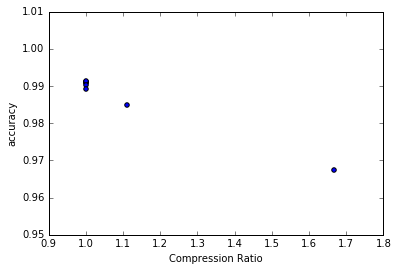

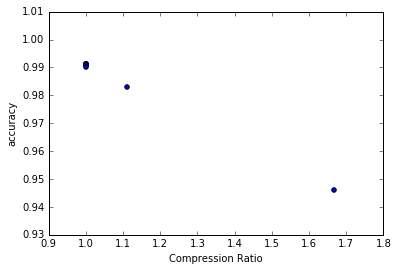

In [14]:
# Single plot accuracy vs size

# mpld3.enable_notebook()
# mpld3.disable_notebook()

for Expt in Expts:
    CompRatio = [(ModelSizeOrig*1.0)/trial['size'] for trial in Expt['Trials']]
    fig = plt.figure()
    fig = plt.scatter(CompRatio[:-1], Expt['accuracies'][:-1], label = Expt['name'])
    ax = fig.axes.set_xlabel('Compression Ratio')
    ax = fig.axes.set_ylabel('accuracy')